In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import branca
import folium
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta, time

test

## Import files

In [33]:
# Full database
df = pd.read_csv('data/data_NS_filtered.csv', sep=";") 
# Codes of stations associated to their commercial name
stations_codes = pd.read_excel("data/data_stations_codes.xlsx")
# GeoJson files that contains the geometry of the location of station
gdf_points = gpd.read_file("data/data_stations_geometry.geojson")

In [34]:
stations = df["station1"].unique().tolist()
stations_codes = stations_codes.loc[stations_codes["Code"].isin(stations)]

df["UITVOERTIJD_VERTREK"] = pd.to_timedelta(df["UITVOERTIJD_VERTREK"].str.split('.').str[0])
df['PLANTIJD_VERTREK'] = pd.to_timedelta(df['PLANTIJD_VERTREK'].str.split('.').str[0])
df['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df['UITVOERTIJD_AANKOMST'].str.split('.').str[0])

In [35]:
# Define the order of stations
#For the high-speed line, the tracks split between Hoofddorp and Niew-Vennep (mettre dans le rapport)

infra = [
    ["Shl", "Hfd", "Rtd"], #High-Speed-line
    ["Shl", "Hfd", "Nvp", "SSh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gvc"], #Slow line Schiphol-Den Haag Central
    ["Shl", "Hfd", "Nvp", "SSh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"],  #Slow line with no stop at Den Haag Central
    ["Gvc", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"], #Slow line Den Haag Central- Rotterdam Central
    ['Rtd', 'Hfd', 'Shl'], #High speed line (reverse)
    ['Gvc', 'Laa', 'Gvm', 'Vst', 'Dvnk', 'Ledn', 'SSh', 'Nvp', 'Hfd', 'Shl'],  #Slow line Schiphol-Den Haag Central(reverse)
    ['Rtd','Sdm','Dtcp','Dt','Rsw','Gvmw','Gv','Laa','Gvm','Vst','Dvnk','Ledn','SSh','Nvp','Hfd','Shl'], #Slow line with no stop at Den Haag Central (reverse)
    ['Rtd', 'Sdm', 'Dtcp', 'Dt', 'Rsw', 'Gvmw', 'Gv', 'Gvc'] #Slow line Den Haag Central- Rotterdam Central(reverse)
]

Associate each station to it's geometry

In [36]:
stations_codes = stations_codes.merge(
    gdf_points[["name","geometry"]], 
    left_on="Commercial Name", 
    right_on="name")
stations_codes = gpd.GeoDataFrame(stations_codes, geometry='geometry')

We split the section given by the variable TRAJECT in multiple sections so that it follows the accurate railway infrastructure

In [37]:
intermediate_sections = df.copy() 
new_rows_all = [] 

rows_to_delete = []
for i, row in intermediate_sections.iterrows():
    trouve = False
    for infrastructure in infra:
        if trouve == False and row["station1"] in infrastructure and row["station2"] in infrastructure[infrastructure.index(row["station1"])+2:]:
            intermediate_stops = infrastructure[infrastructure.index(row["station1"]): infrastructure.index(row["station2"])+1]
            for j in range(1, len(intermediate_stops)):
                section = f"{intermediate_stops[j-1]}_{intermediate_stops[j]}"
                inserted_row = row.copy()
                inserted_row["TRAJECT"] = section
                inserted_row["station1"] = intermediate_stops[j-1]
                inserted_row["station2"] = intermediate_stops[j]
                new_rows_all.append(inserted_row)
            rows_to_delete.append(i)
            trouve = True

intermediate_sections=intermediate_sections.drop(rows_to_delete)
df_new_rows = pd.DataFrame(new_rows_all)
intermediate_sections = pd.concat([intermediate_sections, df_new_rows], ignore_index=True)

Create a table gdf_segments that contains all the informations about a segments (geometry, crowding)

In [38]:
intermediate_sections = intermediate_sections.merge(
        stations_codes, 
        left_on="station1",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Origin_com_name", 
            "Code" : "Origin_code",
            "geometry" : "geometry_origin"
            })
    
intermediate_sections = intermediate_sections.merge(
        stations_codes, 
        left_on="station2",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Destin_com_name", 
            "Code" : "Destin_code",
            "geometry" : "geometry_destination"
            })

In [39]:
gdf_segments = intermediate_sections[["TRAJECT","geometry_origin", "geometry_destination","station1","station2"]].drop_duplicates()
gdf_segments['geometry'] = gdf_segments.apply(
    lambda row: LineString([row['geometry_origin'], row['geometry_destination']]), 
    axis=1
)
gdf_segments = gpd.GeoDataFrame(gdf_segments, geometry='geometry')

crowding_by_traject = intermediate_sections.groupby("TRAJECT")[["REALISATIE","PROGNOSE_REIZEN","AFWIJKING"]].sum().reset_index()
gdf_segments = gdf_segments.merge(
    crowding_by_traject,
    left_on="TRAJECT",
    right_on="TRAJECT",
    how="left"
)
gdf_segments["crowding"] = gdf_segments["REALISATIE"]
gdf_segments = gdf_segments.set_crs("EPSG:4326", allow_override=True)


# Map

Note that GitHub does not print the map in the preview, it needs to be run in VS Code

In [40]:
# code from the 1st workshop on September 9 

# create learn colormap interpolating 3 colors
colors = branca.colormap.LinearColormap(
    ['green', 'yellow', 'red'], vmin=gdf_segments["crowding"].min(), vmax=gdf_segments["crowding"].max())

def weight (val, min_weight, max_weight) : 
    vmin=gdf_segments["crowding"].min()
    vmax=gdf_segments["crowding"].max()
    norm = (val - vmin) / (vmax - vmin)
    return min_weight + norm * (max_weight - min_weight)

# define style function
def raster_choropleth(row):
    return {
        #"fillColor": colors(row['properties']['avg']),
        "color": colors(row['properties']['crowding']),
        "weight": weight (row['properties']['crowding'], 2, 5),
        "fillOpacity": 0.75,
    }

# create base map
# The map is centered on The Hague
poly_map = folium.Map(
        location=[52.05, 4.19],    
        zoom_start=7
    )

# overlay choropleth
gjson = folium.features.GeoJson(
    gdf_segments[['TRAJECT', 'crowding', 'geometry']],
    style_function=raster_choropleth,
    ).add_to(poly_map)

# add Tooltip
folium.features.GeoJsonTooltip(
    fields=['TRAJECT','crowding'],
    aliases=['Segment', 'Crowding']
).add_to(gjson)

# add colormap to the map
poly_map.add_child(colors)

# display
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/crowding.png" alt="Screenshot" width="50%">

# Average deviation per route (bar chart)

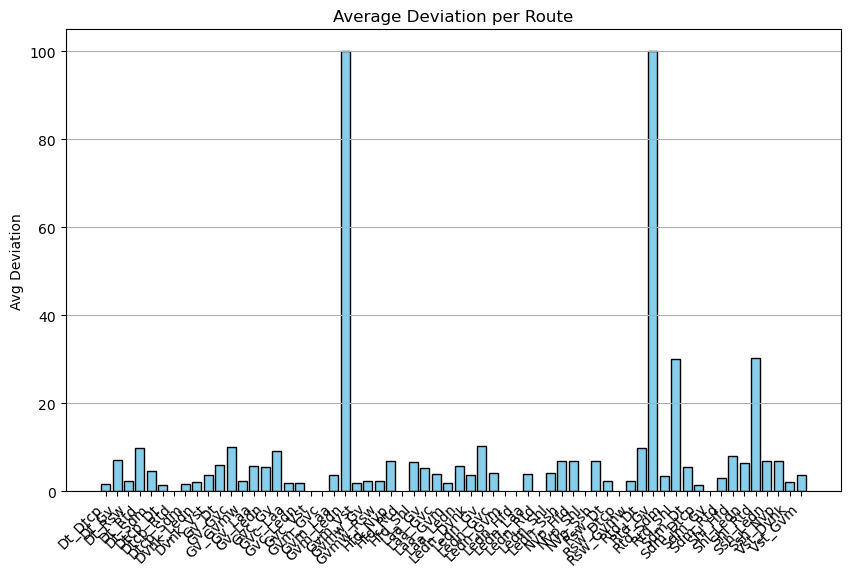

In [41]:
# Group by route
route_stats = df.groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean"
}).reset_index()

plt.figure(figsize=(10,6))
plt.bar(route_stats["TRAJECT"], route_stats["AFWIJKING"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg Deviation")
plt.title("Average Deviation per Route")
plt.grid(axis="y")
plt.show()

# Average deviation per route (map)

Note that GitHub does not print the map in the preview, it needs to be run in VS Code

In [44]:
gdf_route_stats = gdf_segments.groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean", 
    "geometry" : "first",
}).reset_index()

gdf_route_stats = gpd.GeoDataFrame(gdf_route_stats, geometry='geometry')
gdf_route_stats = gdf_route_stats.set_crs("EPSG:4326", allow_override=True)


In [45]:
# create learn colormap interpolating 3 colors
colors = branca.colormap.LinearColormap(
    ['green', 'yellow', 'red'], vmin=gdf_route_stats["AFWIJKING"].min(), vmax=gdf_route_stats["AFWIJKING"].max())

def weight (val, min_weight, max_weight) : 
    vmin=gdf_route_stats["AFWIJKING"].min()
    vmax=gdf_route_stats["AFWIJKING"].max()
    norm = (val - vmin) / (vmax - vmin)
    return min_weight + norm * (max_weight - min_weight)

# define style function
def raster_choropleth(row):
    return {
        #"fillColor": colors(row['properties']['avg']),
        "color": colors(row['properties']["AFWIJKING"]),
        "weight": weight (row['properties']["AFWIJKING"], 2, 5),
        "fillOpacity": 0.75,
    }

# create base map
# The map is centered on The Hague
poly_map = folium.Map(
        location=[52.05, 4.19],    
        zoom_start=7
    )

# overlay choropleth
gjson = folium.features.GeoJson(
    gdf_route_stats[['TRAJECT', "AFWIJKING", 'geometry']],
    style_function=raster_choropleth,
    ).add_to(poly_map)

# add Tooltip
folium.features.GeoJsonTooltip(
    fields=['TRAJECT',"AFWIJKING"],
    aliases=['Segment', 'Average deviation per route']
).add_to(gjson)

# add colormap to the map
poly_map.add_child(colors)

# display
poly_map

Same, here is a screenshot if the map doesn't show properly : 

<img src="images/deviation.png" alt="Screenshot" width="50%">


# Quality of previsions through the day

We group the realised departures times in 10-minutes intervals

In [20]:
# Creation of multiple time intervals to group the trips

quality_of_previsions = df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

# convert to datetime
quality_of_previsions["round_UITVOERTIJD_AANKOMST"] = quality_of_previsions["UITVOERTIJD_AANKOMST"].apply(
    lambda td: (datetime.min + td).time() 
)

# We create a new feature to group the real departure times by 10-minutes intervals 
def round_time_to_interval(t,interval=10):
    """
    It rounds a time of date format 
    Args : 
        t : time in datetime format
        interval (int) : interval for the rounding (exemple : 10-minutes intervals)
    Retunrs : 
        rounded time in date format
    """
    if t is pd.NaT or t is None:
        return None
    dt = datetime.combine(datetime.today(), t)
    total_minutes = dt.hour * 60 + dt.minute
    rounded_minutes = round(total_minutes / interval) * interval
    dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(minutes=rounded_minutes)
    return dt_rounded.time()

quality_of_previsions["round_UITVOERTIJD_AANKOMST"] = quality_of_previsions["round_UITVOERTIJD_AANKOMST"].apply(lambda t : round_time_to_interval(t,10))

mean_deviation = quality_of_previsions.groupby('round_UITVOERTIJD_AANKOMST').agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
}).reset_index()



And plot the diagram

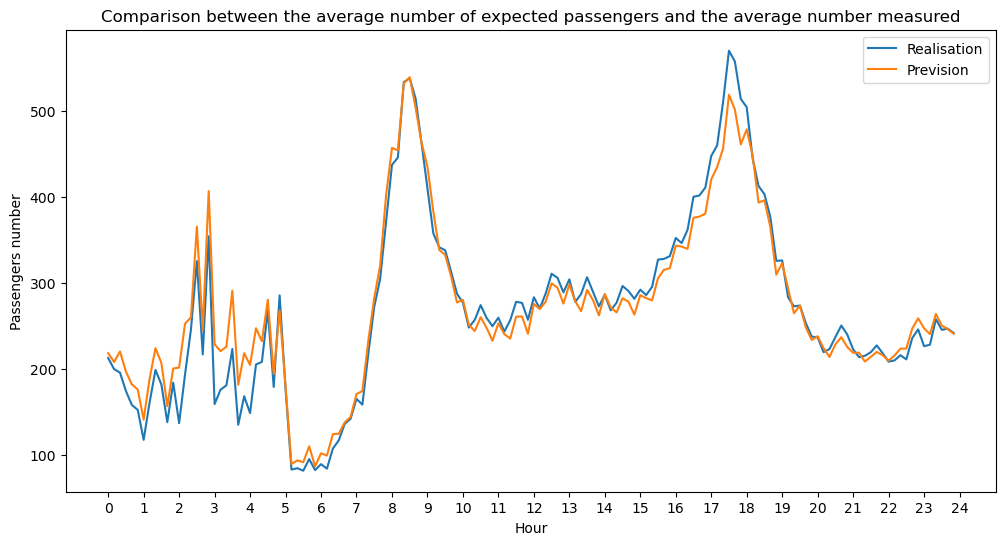

In [21]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)
mean_deviation['minutes'] = mean_deviation['round_UITVOERTIJD_AANKOMST'].apply(
    lambda t: t.hour * 60 + t.minute
)

# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_deviation['minutes'], mean_deviation['REALISATIE'], label='Realisation')
plt.plot(mean_deviation['minutes'], mean_deviation['PROGNOSE_REIZEN'], label='Prevision')

plt.xticks(range(0, 24*60+1, 60), [f"{h}" for h in range(25)])  # ticks every hours
plt.xlabel("Hour")
plt.ylabel("Passengers number")
plt.title("Comparison between the average number of expected passengers and the average number measured")
plt.legend()
plt.show()

# Prevision error compared to the delay of the train at departure time

In [22]:
# We group the delays to intervals of 30 secondes for a nice plot

error_compared_to_delay = df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

error_compared_to_delay["delay"] =pd.to_datetime(error_compared_to_delay["delay"], format="%H:%M:%S").dt.time

def round_time_to_interval_seconds(t, interval_seconds=30):
    """
    It rounds a time of date format 
    Args : 
        t : time in datetime format
        interval (int) : interval for the rounding (exemple : 10-seconds intervals)
    Retunrs : 
        rounded time in date format
    """
    dt = datetime.combine(datetime.today(), t)
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second
    rounded_seconds = round(total_seconds / interval_seconds) * interval_seconds
    dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=rounded_seconds)
    return dt_rounded.time()


error_compared_to_delay["delay_round"] = error_compared_to_delay["delay"].apply(lambda t : round_time_to_interval_seconds(t,30))


In [23]:
# We group the values for each delay interval for a nice plot

mean_delay = error_compared_to_delay.groupby("delay_round").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
    'AFWIJKING' : "mean",
}).reset_index()

mean_delay=mean_delay.loc[mean_delay["delay_round"] < time(hour=2)]


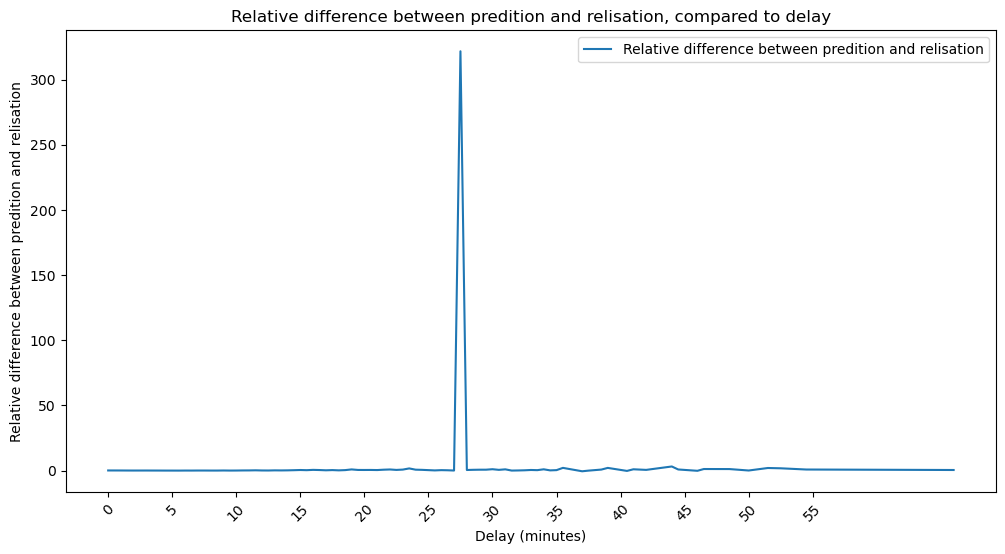

In [24]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)


mean_delay['seconds'] = mean_delay["delay_round"].apply(
    lambda t: t.hour * 3600 + t.minute*60 + t.second)


# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_delay['seconds'], mean_delay['AFWIJKING'], label='Relative difference between predition and relisation')


ticks = range(0, 3600, 300)  # tous les 5 minutes (300 secondes)
labels = [f"{m}" for m in range(0, 60, 5)]
plt.xticks(ticks, labels, rotation=45)
plt.xlabel("Delay (minutes)")
plt.ylabel('Relative difference between predition and relisation')
plt.title('Relative difference between predition and relisation, compared to delay')
plt.legend()
plt.show()

#the pic is due to an aberration at 27:30 delay --->>> DATA CLEANING

# Average delay on all of the network 

First, we have to group the line of the dataframes to only get 1 delay per train. 
But for this purpose, two approaches can be used. Lets take the example of a train running from Shl to Gvc. Let's say that this train has a 11min38 delay from Shl to Hfd, 11min43 delay from Hfd to Ledn, and a 11min35 delay from Ledn to Gvc (it catches up a little on the last section). 
- First approach : we take the maximum delay encountered by the train. For this example, it should be 11min43
- Second approach : we take te final delay of the train at it's final station. For this example, it should be 11min35.

I think that the second approach is the most relevant one, but the two of them are written below, and one just need to comment/uncomment the two lines.

In [46]:
df_delay_per_train= df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

df_delay_per_train["delay"] =pd.to_datetime(df_delay_per_train["delay"], format="%H:%M:%S").dt.time
df_delay_per_train["delay_seconds"] = df_delay_per_train["delay"].apply(lambda t: t.hour*3600 + t.minute*60 + t.second)

#FIRST APPROACH : 
#idx = df_delay_per_train.groupby(["DAGNR", "BEWEGINGNUMMER"])["delay_seconds"].idxmax()

#SECOND APPROACH : 
idx = df_delay_per_train.groupby(["DAGNR", "BEWEGINGNUMMER"]).tail(1).index


df_delay_per_train = df_delay_per_train.loc[idx].reset_index(drop=True)

def mean_delays(period, df) : 
    df_selection = df.loc[df["DAGDEELTREIN"]==period]
    mean = df_selection["delay_seconds"].mean()
    return (datetime.min + timedelta(seconds=mean)).time()

morning = mean_delays("Ochtendspits", df_delay_per_train)
evening = mean_delays("Avondspits", df_delay_per_train)
offpeak = mean_delays("Daluren", df_delay_per_train)
weekend = mean_delays("Weekend", df_delay_per_train)

print(
    f"Mean delay in the morning peak: {morning.hour} hour(s) {morning.minute} minute(s) {morning.second} second(s) \n"
    f"Mean delay in the evening peak: {evening.hour} hour(s) {evening.minute} minute(s) {evening.second} second(s) \n"
    f"Mean delay in the off peak: {offpeak.hour} hour(s) {offpeak.minute} minute(s) {offpeak.second} second(s)\n"
    f"Mean delay in the week-end: {weekend.hour} hour(s) {weekend.minute} minute(s) {weekend.second} second(s)"
)

Mean delay in the morning peak: 0 hour(s) 1 minute(s) 4 second(s) 
Mean delay in the evening peak: 0 hour(s) 1 minute(s) 38 second(s) 
Mean delay in the off peak: 0 hour(s) 1 minute(s) 18 second(s)
Mean delay in the week-end: 0 hour(s) 1 minute(s) 8 second(s)
